#### Import Packages

In [47]:
import datasets
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
import keras 
import numpy as np
import pandas as pd
from skimage.transform import resize
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

#### Import and Clean Data

In [8]:
import datasets
dataset = datasets.load_dataset("renumics/food101-enriched", split="train")

/Users/tylerknohl/opt/anaconda3/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for renumics/food101-enriched contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/renumics/food101-enriched
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [9]:
# Only looking at 10 classes because our computers can only handle the specified amount.
df_show = dataset.to_pandas()
working_dataset = df_show[df_show['label'] < 10]
working_dataset

,image,label,label_str,split
0,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train
1,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train
2,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train
3,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train
4,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train
...,...,...,...,...
68995,/Users/tylerknohl/.cache/huggingface/datasets/...,7,bibimbap,train
68996,/Users/tylerknohl/.cache/huggingface/datasets/...,7,bibimbap,train
68997,/Users/tylerknohl/.cache/huggingface/datasets/...,7,bibimbap,train
68998,/Users/tylerknohl/.cache/huggingface/datasets/...,7,bibimbap,train


In [10]:
# Function to turn the links in the dataframe to pixel values
def link_to_pixels(row):
    image = Image.open(row['image'])
    image_np = np.array(image)
    return image_np

# Apply the function to the pixels
working_dataset['pixels'] = working_dataset.apply(link_to_pixels, axis=1)

/var/folders/0h/w2m92r890n75jg04_99g1qpc0000gn/T/ipykernel_83525/30025164.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_dataset['pixels'] = working_dataset.apply(link_to_pixels, axis=1)


In [11]:
# Apply a lambda to the pixels to get the shape of the image. 
working_dataset['pixel_shape'] = working_dataset.apply(lambda x: x['pixels'].shape, axis=1)
working_dataset.head()

/var/folders/0h/w2m92r890n75jg04_99g1qpc0000gn/T/ipykernel_83525/3254863817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_dataset['pixel_shape'] = working_dataset.apply(lambda x: x['pixels'].shape, axis=1)


,image,label,label_str,split,pixels,pixel_shape
0,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[31, 35, 34], [29, 33, 32], [26, 30, 29], [2...","(512, 384, 3)"
1,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[245, 224, 229], [242, 221, 226], [238, 217,...","(512, 512, 3)"
2,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[140, 125, 120], [141, 126, 121], [142, 127,...","(383, 512, 3)"
3,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[111, 99, 77], [117, 105, 83], [119, 107, 85...","(348, 512, 3)"
4,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[222, 218, 219], [225, 221, 222], [227, 223,...","(512, 512, 3)"


In [12]:
# Filter the working_dataset to include only rows where 'pixel_shape' has exactly three elements
# this should get rid of any black and white image
working_dataset = working_dataset[working_dataset['pixel_shape'].apply(lambda x: len(x) == 3)]

# Display the first few rows of the filtered working_dataset to verify
working_dataset.head()

,image,label,label_str,split,pixels,pixel_shape
0,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[31, 35, 34], [29, 33, 32], [26, 30, 29], [2...","(512, 384, 3)"
1,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[245, 224, 229], [242, 221, 226], [238, 217,...","(512, 512, 3)"
2,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[140, 125, 120], [141, 126, 121], [142, 127,...","(383, 512, 3)"
3,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[111, 99, 77], [117, 105, 83], [119, 107, 85...","(348, 512, 3)"
4,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[222, 218, 219], [225, 221, 222], [227, 223,...","(512, 512, 3)"


#### Add Padding to the data

In [13]:
# Pads an image to 512x512 by calculating the padding needed for each side.
def pad_image(image_row):
 
    image_np = image_row['pixels']

    target_height = target_width = 512
    
    pad_color = [0, 0, 0]
    
    original_height, original_width, channels = image_np.shape
    padding_height = max(target_height - original_height, 0)
    padding_width = max(target_width - original_width, 0)
    top = padding_height // 2
    bottom = padding_height - top
    left = padding_width // 2
    right = padding_width - left
    padded_img = np.full((target_height, target_width, channels), pad_color, dtype=np.uint8)

    padded_img[top:top+original_height, left:left+original_width] = image_np
    image_row['pixel_shape'] = padded_img.shape
    return padded_img

In [14]:
# Run pad_image on pixels
working_dataset['pixels'] = working_dataset.apply(pad_image, axis=1)
working_dataset.head()

/var/folders/0h/w2m92r890n75jg04_99g1qpc0000gn/T/ipykernel_83525/2913510168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_dataset['pixels'] = working_dataset.apply(pad_image, axis=1)


,image,label,label_str,split,pixels,pixel_shape
0,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(512, 384, 3)"
1,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[245, 224, 229], [242, 221, 226], [238, 217,...","(512, 512, 3)"
2,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(383, 512, 3)"
3,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","(348, 512, 3)"
4,/Users/tylerknohl/.cache/huggingface/datasets/...,6,beignets,train,"[[[222, 218, 219], [225, 221, 222], [227, 223,...","(512, 512, 3)"


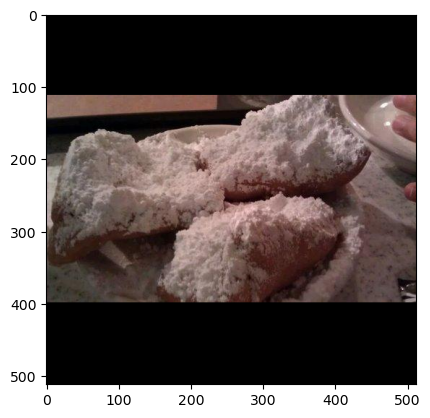

In [18]:
# Sample some of the work in the image. 
# Display the image and show the padding added. 
first_image_data = working_dataset.iloc[200]['pixels']
plt.imshow(first_image_data)
plt.axis('on')  
plt.show()

In [19]:
# Resize the images to 100x100 by putting them in batches to avoid computer crashes. 
def resize_images_in_batches(images, batch_size, new_shape):
    resized_images = []
    num_images = len(images)
    num_batches = (num_images + batch_size - 1) // batch_size  

    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, num_images)
        batch_images = images[start_index:end_index]
        
        resized_batch = [resize(image, new_shape, anti_aliasing=True) for image in batch_images]
        resized_images.extend(resized_batch)
        print(f"Processed batch {batch_index + 1}/{num_batches}")

    return resized_images

input_images = working_dataset['pixels']  
batch_size = 100  
new_shape = (100, 100) 

resized_images = resize_images_in_batches(input_images, batch_size, new_shape)

Processed batch 1/75
Processed batch 2/75
Processed batch 3/75
Processed batch 4/75
Processed batch 5/75
Processed batch 6/75
Processed batch 7/75
Processed batch 8/75
Processed batch 9/75
Processed batch 10/75
Processed batch 11/75
Processed batch 12/75
Processed batch 13/75
Processed batch 14/75
Processed batch 15/75
Processed batch 16/75
Processed batch 17/75
Processed batch 18/75
Processed batch 19/75
Processed batch 20/75
Processed batch 21/75
Processed batch 22/75
Processed batch 23/75
Processed batch 24/75
Processed batch 25/75
Processed batch 26/75
Processed batch 27/75
Processed batch 28/75
Processed batch 29/75
Processed batch 30/75
Processed batch 31/75
Processed batch 32/75
Processed batch 33/75
Processed batch 34/75
Processed batch 35/75
Processed batch 36/75
Processed batch 37/75
Processed batch 38/75
Processed batch 39/75
Processed batch 40/75
Processed batch 41/75
Processed batch 42/75
Processed batch 43/75
Processed batch 44/75
Processed batch 45/75
Processed batch 46/

In [76]:
# Turn the datframe into a series for modelling. 
X = pd.Series(resized_images)
y = working_dataset['label'].values

# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)

#### Logistic Regression

In [77]:
# Flatten each image in X_train
X_train_flattened = [np.array(image).flatten() for image in X_train]

# Convert to a NumPy array
X_train_flattened = np.array(X_train_flattened)

# Train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_flattened, y_train)

/Users/tylerknohl/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [78]:
# Predict Y and return metrics on training data
y_pred_train = logistic_model.predict(X_train_flattened)

conf_matrix = confusion_matrix(y_train, y_pred_train)
accuracy = accuracy_score(y_train,y_pred_train)
precision = precision_score(y_train, y_pred_train, average='micro')
recall = recall_score(y_train, y_pred_train, average='micro')
f1 = f1_score(y_train, y_pred_train, average='micro')
print('Train Confusion Matrix\n', conf_matrix)
print('Train Accuracy', accuracy)
print('Train Precision', precision)
print('Train Recall', recall)
print('Train F1', f1)

Train Confusion Matrix
 [[322  27  46  18  37  22  34  30  22  42]
 [ 25 363  21  32  34  33  24  17  31  20]
 [ 47  23 323  18  34  17  26  22  39  51]
 [ 21  33  10 396  33  22  21  20  18  26]
 [ 32  53  37  44 277  40  37  14  35  31]
 [ 27  34  20  43  38 330  27  22  22  37]
 [ 15  25  14  16  25  16 422  13  32  22]
 [ 36  18  18  15  13  22  17 417  17  27]
 [ 42  43  42  26  33  29  41  27 275  41]
 [ 32  23  34  25  31  24  25  34  41 331]]
Train Accuracy 0.5760960160026671
Train Precision 0.5760960160026671
Train Recall 0.5760960160026671
Train F1 0.5760960160026671


In [79]:
# Flatten each image in X_test
X_test_flattened = [np.array(image).flatten() for image in X_test]

# Convert the list of flattened images to a NumPy array
X_test_flattened = np.array(X_test_flattened)

# Predict Y and return metrics on training data
y_pred_test = logistic_model.predict(X_test_flattened)

conf_matrix = confusion_matrix(y_test, y_pred_test)
accuracy = accuracy_score(y_test,y_pred_test)
precision = precision_score(y_test, y_pred_test, average='weighted')
recall = recall_score(y_test, y_pred_test, average='weighted')
f1 = f1_score(y_test, y_pred_test, average='weighted')
print('Test Confusion Matrix\n', conf_matrix)
print('Test Accuracy', accuracy)
print('Test Precision', precision)
print('Test Recall', recall)
print('Test F1', f1)

Test Confusion Matrix
 [[25 15 22  6 13  7 10 20 15 17]
 [ 9 28 12 15 23 21 10  7 13 12]
 [31  2 37  1  3 10 12 20 18 16]
 [ 7  8  7 58 14 18  9 11  8 10]
 [14 20 14 12 25 21  9  8 13 14]
 [10 15 13 20 18 29 12  6 10 17]
 [ 6 14  6  3 11  7 61 11 15 16]
 [17  5 19  9  4  8 13 61  5  9]
 [17 18 11  9  9 20 16 11 24 15]
 [21  7 17  7 12 15 10 13 18 30]]
Test Accuracy 0.252
Test Precision 0.2499719196461055
Test Recall 0.252
Test F1 0.25053970347922194


#### Logistic Regression with Regularization

In [80]:
# Train the logistic regression model with regularization 
logistic_model = LogisticRegression(C=0.01)
logistic_model.fit(X_train_flattened, y_train)

# Predictions and accuracy on the training set
y_pred_train = logistic_model.predict(X_train_flattened)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Training Confusion Matrix:")
print(conf_matrix_train)
print("Training Accuracy:", accuracy_score(y_train, y_pred_train))

# Predictions and accuracy on the testing set
y_pred_test = logistic_model.predict(X_test_flattened)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Testing Confusion Matrix:")
print(conf_matrix_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))

/Users/tylerknohl/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Confusion Matrix:
[[316  28  46  19  44  16  42  32  22  35]
 [ 28 341  22  34  41  38  24  15  35  22]
 [ 51  24 312  16  41  18  28  28  37  45]
 [ 22  32   7 397  36  26  21  17  21  21]
 [ 36  53  29  41 281  35  42  15  39  29]
 [ 22  42  16  38  45 326  31  22  21  37]
 [ 19  28   9  14  23  20 425  12  27  23]
 [ 30  15  14  18  11  21  20 420  21  30]
 [ 43  42  49  23  35  32  51  34 249  41]
 [ 30  16  43  23  35  28  39  32  37 317]]
Training Accuracy: 0.5640940156692782
Testing Confusion Matrix:
[[26 10 16  7 12  9 15 24 13 18]
 [10 25 12 17 26 21  8  7 13 11]
 [27  2 39  3  5  8 16 21 18 11]
 [ 8  8  6 58 12 19 10 12  8  9]
 [15 15 12 13 30 22  3  8 14 18]
 [12 13 11 17 20 31 15  5 12 14]
 [ 7  8  4  4 11  7 74 11  9 15]
 [14  3 13 10  7  7 15 59  6 16]
 [16 17 14  9  9 20 22 11 22 10]
 [21  6 15  5 11 13 16 12 18 33]]
Testing Accuracy: 0.26466666666666666


#### Feed Forward Neural Network

Epoch 1/32
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.1440 - loss: 4.1856 - val_accuracy: 0.1983 - val_loss: 2.2038
Epoch 2/32
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2177 - loss: 2.1905 - val_accuracy: 0.1842 - val_loss: 2.2486
Epoch 3/32
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2220 - loss: 2.1242 - val_accuracy: 0.2233 - val_loss: 2.1517
Epoch 4/32
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.2268 - loss: 2.1042 - val_accuracy: 0.2050 - val_loss: 2.1750
Epoch 5/32
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.2371 - loss: 2.0975 - val_accuracy: 0.2400 - val_loss: 2.1531
Epoch 6/32
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.2415 - loss: 2.0598 - val_accuracy: 0.2250 - val_loss: 2.1435
Epoch 7/32
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2246 - loss: 2.0626 - val_accuracy: 0.2200 - val_loss: 2.1773
Epoch 8/32
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.2490 - loss: 2.0382 - val_accu

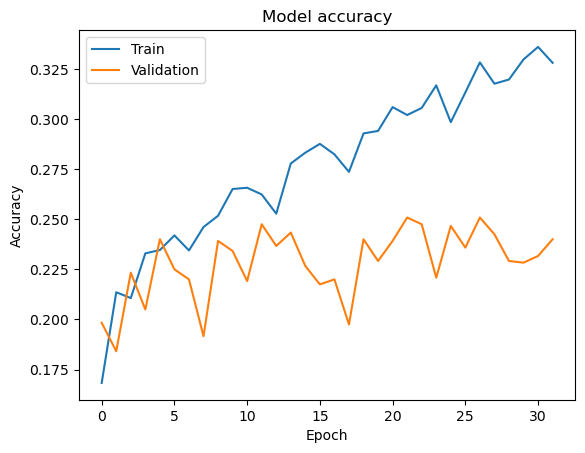

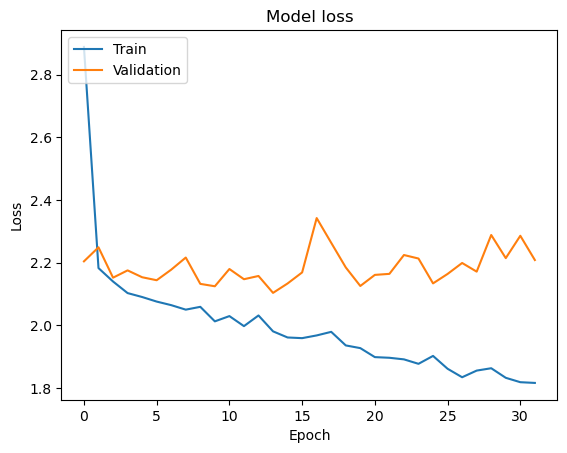

In [51]:
model = Sequential([
    InputLayer(input_shape=(100, 100, 3)),  
    Flatten(),  
    Dense(128, activation='relu'), 
    Dense(128, activation='relu'),   
   Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


uniform_arrays = [x if x.shape == (100, 100, 3) else np.resize(x, (100, 100, 3)) for x in X_train]
X_train_array = np.array(uniform_arrays, dtype=np.float32)

history = model.fit(X_train_array, y_train, epochs=32, validation_split=0.2)

# Plot training & validation accuracy values 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
# Assuming X_test is a list of numpy arrays (each an image), ensure all are the same shape
uniform_arrays_test = [x if x.shape == (100, 100, 3) else np.resize(x, (100, 100, 3)) for x in X_test]
X_test_array = np.array(uniform_arrays_test, dtype=np.float32)

In [53]:
# Print the loss and accuracy for the FNN 
test_loss, test_accuracy = model.evaluate(X_test_array, y_test)

print(f'Loss: {test_loss}')
print(f'accuracy: {test_accuracy}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2365 - loss: 2.2565
Loss: 2.2722694873809814
accuracy: 0.23133333027362823


#### Convolutional Neural Network

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.1819 - loss: 2.4615 - val_accuracy: 0.3242 - val_loss: 1.9249
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.4290 - loss: 1.6695 - val_accuracy: 0.3658 - val_loss: 1.8179
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.5807 - loss: 1.3074 - val_accuracy: 0.3525 - val_loss: 1.8802
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7099 - loss: 0.9744 - val_accuracy: 0.3508 - val_loss: 1.9888
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.8355 - loss: 0.6385 - val_accuracy: 0.3442 - val_loss: 2.0698
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9191 - loss: 0.4064 - val_accuracy: 0.3383 - val_loss: 2.3044
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9515 - loss: 0.2649 - val_accuracy: 0.3192 - val_loss: 2.5261
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.9824 - loss: 0.1577 - 

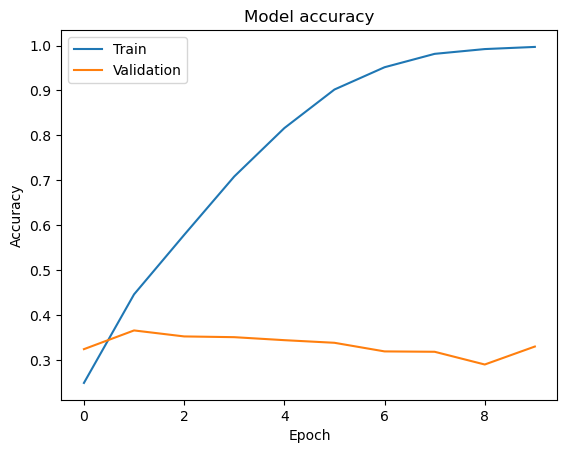

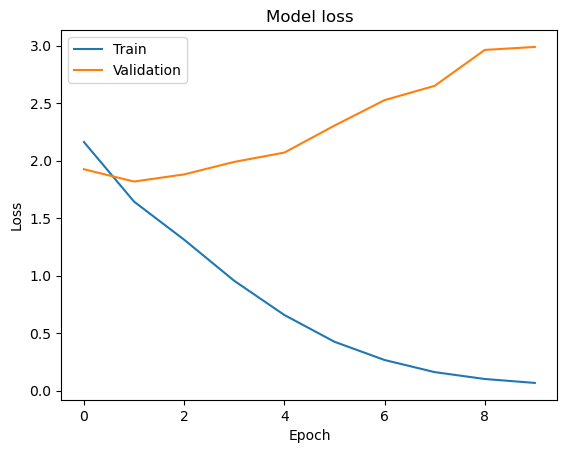

In [69]:
model_cnn = Sequential([
    Input(shape=(100, 100, 3)),  # Adjust the shape based on your actual input data dimensions
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(10, activation='softmax')  # Adjust according to the number of classes
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Example: Adam optimizer with a learning rate of 0.001

# Compile the model with the chosen optimizer and loss function
model_cnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming X_train and y_train are your training data
batch_size = 32  # Example batch size
epochs = 10  # Example number of epochs

# Train the CNN model using model.fit
uniform_arrays = [x if x.shape == (100, 100, 3) else np.resize(x, (100, 100, 3)) for x in X_train]
X_train_array = np.array(uniform_arrays, dtype=np.float32)
history = model_cnn.fit(X_train_array, y_train, batch_size=batch_size, epochs=epochs,  validation_split=0.2)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [71]:
uniform_arrays_test = [x if x.shape == (100, 100, 3) else np.resize(x, (100, 100, 3)) for x in X_test]
X_test_array = np.array(uniform_arrays_test, dtype=np.float32)

In [72]:
# Print the loss and accuracy for the CNN
test_loss, test_accuracy = model_cnn.evaluate(X_test_array, y_test)

print(f'Loss: {test_loss}')
print(f'accuracy: {test_accuracy}')

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3322 - loss: 2.7542
Loss: 2.744523763656616
accuracy: 0.3466666638851166
